# Masked Evidence Lower Bound

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import io
mask_path = "~/Desktop/MCAR60_mask.csv"
X_full_path = "~/Desktop/MCAR60_X_full.csv"
X_obs_path ="~/Desktop/MCAR60_X_obs.csv"


x_full = pd.read_csv(X_full_path).to_numpy().astype("float32")
x_obs  = pd.read_csv(X_obs_path ).to_numpy().astype("float32")
mask   = pd.read_csv(mask_path  ).to_numpy().astype("float32")

x_obs = np.where(mask == 1, x_obs, 0.0)

In [2]:
print(mask.mean())
print( x_obs.mean())
print( x_full.mean())

0.59926665
nan
0.51131666


In [3]:
METHOD = "zero"   # "zero" | "enc_ind" | "enc_dec_ind"

def build_inputs(x_obs, mask, method):
    if method == "zero":
        enc_inp = x_obs
        dec_cond = None
    elif method == "enc_ind":
        enc_inp = torch.cat([x_obs, mask], dim=1)
        dec_cond = None
    elif method == "enc_dec_ind":
        enc_inp = torch.cat([x_obs, mask], dim=1)
        dec_cond = mask
    else:
        raise ValueError("Unknown method")
    return enc_inp, dec_cond

In [4]:
x_full_t = torch.from_numpy(x_full).float()
x_obs_t  = torch.from_numpy(x_obs).float()
mask_t   = torch.from_numpy(mask).float()

x_obs_t = torch.nan_to_num(x_obs_t, nan=0.0)

In [5]:
N = x_full_t.shape[0]
test_train_mask = torch.rand(N) < (1/3)   # True = test

x_full_test, x_full_train = x_full_t[test_train_mask], x_full_t[~test_train_mask]
x_obs_test,  x_obs_train  = x_obs_t [test_train_mask], x_obs_t [~test_train_mask]
mask_test,   mask_train   = mask_t  [test_train_mask], mask_t  [~test_train_mask]

In [6]:
# Model Hyperparameters

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 100

x_dim = 20
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

In [7]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 100
kwargs = {'num_workers': 1, 'pin_memory': True}

train_ds = TensorDataset(x_obs_train, x_full_train, mask_train)
test_ds  = TensorDataset(x_obs_test,  x_full_test,  mask_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  **kwargs)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, **kwargs)

In [8]:
class Encoder(nn.Module):
    """Gaussian MLP Encoder."""
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)

        return mean, log_var

In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, use_mask=False, x_dim=20):
        super().__init__()
        self.use_mask = use_mask
        in_dim = latent_dim + (x_dim if use_mask else 0)

        self.FC_hidden = nn.Linear(in_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, z, mask=None):
        if self.use_mask:
            z = torch.cat([z, mask], dim=1)

        h = self.LeakyReLU(self.FC_hidden(z))
        h = self.LeakyReLU(self.FC_hidden2(h))
        return torch.sigmoid(self.FC_output(h))

In [10]:
class Model(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparametrization(self, mean, std):
        eps = torch.randn_like(std)
        return mean + std * eps

    def forward(self, enc_inp, dec_mask=None):
        mean, log_var = self.encoder(enc_inp)
        log_var = torch.clamp(log_var, -10.0, 10.0)  # 稳定一点
        std = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, std)
        x_hat = self.decoder(z, mask=dec_mask)
        return x_hat, mean, log_var

In [11]:
enc_input_dim = x_dim if METHOD == "zero" else 2 * x_dim
use_dec_mask = (METHOD == "enc_dec_ind")

encoder = Encoder(input_dim=enc_input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim,
                  use_mask=use_dec_mask, x_dim=x_dim)

model = Model(encoder, decoder).to(DEVICE)

### 3. Define Loss Function

In [12]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()


def loss_function(x_full, x_hat, mean, log_var, mask, beta=1.0):
    # Reconstruction loss on observed entries only
    recon_all = nn.functional.binary_cross_entropy(
        x_hat, x_full, reduction='none'
    )
    recon_obs = (recon_all * mask).sum() / (mask.sum() + 1e-8)

    # KL divergence (per batch)
    kld = -0.5 * torch.sum(
        1 + log_var - mean.pow(2) - log_var.exp()
    ) / x_full.size(0)

    return recon_obs + beta * kld


optimizer = Adam(model.parameters(), lr=lr)

### 4. Train the Model

In [13]:
from torch.optim import Adam

def train_one_method(method, train_loader, test_loader,
                     x_dim=20, hidden_dim=400, latent_dim=200,
                     lr=1e-3, epochs=30, device="cpu", beta=1.0):

    # build model dims
    enc_input_dim = x_dim if method == "zero" else 2 * x_dim
    use_dec_mask = (method == "enc_dec_ind")

    encoder = Encoder(input_dim=enc_input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
    decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim,
                      use_mask=use_dec_mask, x_dim=x_dim)

    model = Model(encoder, decoder).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    history = {"train_missing_bce": [], "test_missing_bce": []}

    for epoch in range(epochs):
        model.train()
        train_miss_losses = []

        for x_obs, x_full, mask in train_loader:
            x_obs = x_obs.to(device).float()
            x_full = x_full.to(device).float()
            mask = mask.to(device).float()

            enc_inp, dec_mask = build_inputs(x_obs, mask, method)

            optimizer.zero_grad()
            x_hat, mean, log_var = model(enc_inp, dec_mask)

            # loss = observed recon + KL
            recon_obs = masked_bce(x_hat, x_full, mask)
            kld = kld_loss(mean, log_var)
            loss = recon_obs + beta * kld

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            # track missing-only BCE as imputation metric
            miss_bce_val = missing_bce(x_hat.detach(), x_full, mask).item()
            train_miss_losses.append(miss_bce_val)

        # evaluate missing BCE on test
        model.eval()
        test_miss_losses = []
        with torch.no_grad():
            for x_obs, x_full, mask in test_loader:
                x_obs = x_obs.to(device).float()
                x_full = x_full.to(device).float()
                mask = mask.to(device).float()

                enc_inp, dec_mask = build_inputs(x_obs, mask, method)
                x_hat, mean, log_var = model(enc_inp, dec_mask)

                test_miss_losses.append(missing_bce(x_hat, x_full, mask).item())

        history["train_missing_bce"].append(float(np.mean(train_miss_losses)))
        history["test_missing_bce"].append(float(np.mean(test_miss_losses)))

        print(f"[{method}] Epoch {epoch+1:02d} | "
              f"train missing BCE={history['train_missing_bce'][-1]:.4f} | "
              f"test missing BCE={history['test_missing_bce'][-1]:.4f}")

    return model, history

In [14]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def masked_bce(x_hat, x_target, mask):
    """BCE only on mask==1 entries"""
    bce = F.binary_cross_entropy(x_hat, x_target, reduction="none")
    return (bce * mask).sum() / (mask.sum() + 1e-8)

def missing_bce(x_hat, x_target, mask):
    """BCE only on missing entries (mask==0)"""
    bce = F.binary_cross_entropy(x_hat, x_target, reduction="none")
    miss = 1.0 - mask
    return (bce * miss).sum() / (miss.sum() + 1e-8)

def kld_loss(mean, log_var):
    return -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) / mean.size(0)

In [15]:
METHODS = ["zero", "enc_ind", "enc_dec_ind"]

all_hist = {}
final_scores = {}

for METHOD in METHODS:
    print("\n==============================")
    print("Running:", METHOD)
    print("==============================")

    model, hist = train_one_method(
        method=METHOD,
        train_loader=train_loader,
        test_loader=test_loader,
        x_dim=x_dim,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        lr=lr,
        epochs=epochs,
        device=DEVICE,
        beta=1.0
    )

    all_hist[METHOD] = hist
    final_scores[METHOD] = hist["test_missing_bce"][-1]


Running: zero


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[zero] Epoch 01 | train missing BCE=0.6408 | test missing BCE=0.6244
[zero] Epoch 02 | train missing BCE=0.6277 | test missing BCE=0.6249
[zero] Epoch 03 | train missing BCE=0.6280 | test missing BCE=0.6258
[zero] Epoch 04 | train missing BCE=0.6282 | test missing BCE=0.6239
[zero] Epoch 05 | train missing BCE=0.6280 | test missing BCE=0.6214
[zero] Epoch 06 | train missing BCE=0.6286 | test missing BCE=0.6218
[zero] Epoch 07 | train missing BCE=0.6280 | test missing BCE=0.6208
[zero] Epoch 08 | train missing BCE=0.6271 | test missing BCE=0.6239
[zero] Epoch 09 | train missing BCE=0.6265 | test missing BCE=0.6226
[zero] Epoch 10 | train missing BCE=0.6264 | test missing BCE=0.6247
[zero] Epoch 11 | train missing BCE=0.6273 | test missing BCE=0.6221
[zero] Epoch 12 | train missing BCE=0.6263 | test missing BCE=0.6190
[zero] Epoch 13 | train missing BCE=0.6269 | test missing BCE=0.6240
[zero] Epoch 14 | train missing BCE=0.6275 | test missing BCE=0.6220
[zero] Epoch 15 | train missing BC

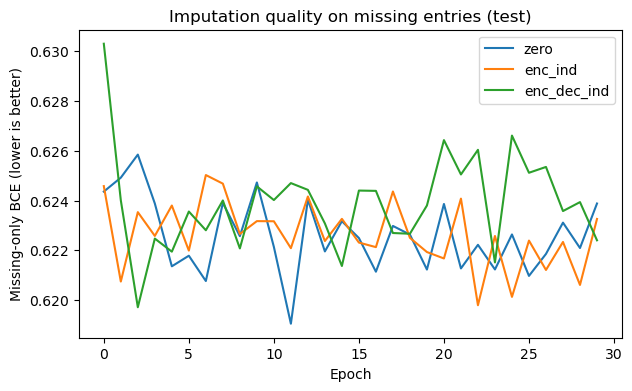

In [16]:
plt.figure(figsize=(7,4))
for METHOD in METHODS:
    plt.plot(all_hist[METHOD]["test_missing_bce"], label=METHOD)
plt.xlabel("Epoch")
plt.ylabel("Missing-only BCE (lower is better)")
plt.title("Imputation quality on missing entries (test)")
plt.legend()
plt.show()

## MB reporting + Expected vs MI draws

In [17]:
import torch
import numpy as np
import pandas as pd

# -----------------------------
# 1) Utilities: score functions
# -----------------------------
def expected_scores(P_hat):
    """
    P_hat: torch.Tensor [N, I], values in [0,1]
    returns expected PC and expected TS
    """
    exp_pc = P_hat.mean(dim=1)      # [N]
    exp_ts = P_hat.sum(dim=1)       # [N]
    return exp_pc, exp_ts


def mi_draw_scores(P_hat, m=20, seed=0):
    """
    Multiple-imputation style:
    draw m completed 0/1 matrices from Bernoulli(P_hat),
    compute PC/TS per draw.
    returns:
      pc_draws: [m, N]
      ts_draws: [m, N]
    """
    g = torch.Generator(device=P_hat.device)
    g.manual_seed(seed)

    draws = []
    for k in range(m):
        X_draw = torch.bernoulli(P_hat, generator=g)  # [N, I]
        pc_k = X_draw.mean(dim=1)   # [N]
        ts_k = X_draw.sum(dim=1)    # [N]
        draws.append((pc_k, ts_k))

    pc_draws = torch.stack([d[0] for d in draws], dim=0)  # [m, N]
    ts_draws = torch.stack([d[1] for d in draws], dim=0)  # [m, N]
    return pc_draws, ts_draws


# ---------------------------------------
# 2) Rubin combine for MI (group-level)
# ---------------------------------------
def rubin_combine(estimates, variances):
    """
    estimates: np.array [m]  (e.g. group mean in each imputed dataset)
    variances: np.array [m]  (e.g. within-imputation variance of the mean)

    returns combined mean and total variance
    """
    m = len(estimates)
    Q_bar = estimates.mean()
    U_bar = variances.mean()
    B = estimates.var(ddof=1)
    T = U_bar + (1 + 1/m) * B
    return Q_bar, T


def group_stats_expected(score, group=None):
    """
    score: torch [N]
    group: torch [N] int labels or None
    returns dict
    """
    score = score.detach().cpu().numpy()

    if group is None:
        return {
            "group": "ALL",
            "n": len(score),
            "mean": float(score.mean()),
            "sd": float(score.std(ddof=1))
        }

    group = group.detach().cpu().numpy()
    out = []
    for g in np.unique(group):
        idx = (group == g)
        out.append({
            "group": int(g),
            "n": int(idx.sum()),
            "mean": float(score[idx].mean()),
            "sd": float(score[idx].std(ddof=1))
        })
    return out


def group_stats_mi(score_draws, group=None):
    """
    score_draws: torch [m, N]
    group: torch [N] or None

    We compute group mean for each draw, then Rubin combine.
    """
    score_draws = score_draws.detach().cpu().numpy()  # [m, N]
    m, N = score_draws.shape

    if group is None:
        # overall mean per draw
        means = score_draws.mean(axis=1)  # [m]
        # within-imputation variance of the mean: var(score)/n
        vars_mean = score_draws.var(axis=1, ddof=1) / N
        Q_bar, T = rubin_combine(means, vars_mean)
        return {
            "group": "ALL",
            "n": N,
            "MI_mean": float(Q_bar),
            "MI_se": float(np.sqrt(T))
        }

    group = group.detach().cpu().numpy()
    out = []
    for g in np.unique(group):
        idx = (group == g)
        n_g = idx.sum()
        means = score_draws[:, idx].mean(axis=1)  # [m]
        vars_mean = score_draws[:, idx].var(axis=1, ddof=1) / n_g
        Q_bar, T = rubin_combine(means, vars_mean)

        out.append({
            "group": int(g),
            "n": int(n_g),
            "MI_mean": float(Q_bar),
            "MI_se": float(np.sqrt(T))
        })
    return out


# ---------------------------------------
# 3) Get predicted P_hat for a METHOD
# ---------------------------------------
def predict_probs(model, method, loader, device):
    """
    returns P_hat_all: torch [N, I] predicted probabilities on entire loader
    """
    model.eval()
    all_p = []
    with torch.no_grad():
        for x_obs, x_full, mask in loader:
            x_obs = x_obs.to(device).float()
            mask = mask.to(device).float()

            enc_inp, dec_mask = build_inputs(x_obs, mask, method)
            x_hat, _, _ = model(enc_inp, dec_mask)  # x_hat in [0,1]
            all_p.append(x_hat.detach().cpu())

    return torch.cat(all_p, dim=0)  # [N, I]


# ---------------------------------------
# 4) Run MB reporting for all methods
# ---------------------------------------
METHODS = ["zero", "enc_ind", "enc_dec_ind"]
m_draws = 20

summary_rows = []

for METHOD in METHODS:
    print("\n==============================")
    print("MB reporting for:", METHOD)
    print("==============================")

    # Train model (your function)
    model, hist = train_one_method(
        method=METHOD,
        train_loader=train_loader,
        test_loader=test_loader,
        x_dim=x_dim,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        lr=lr,
        epochs=epochs,
        device=DEVICE,
        beta=1.0
    )

    # Predict probabilities on test set
    P_hat = predict_probs(model, METHOD, test_loader, DEVICE)  # [N_test, I]

    # ---- Expected scores ----
    exp_pc, exp_ts = expected_scores(P_hat)

    exp_pc_stats = group_stats_expected(exp_pc, group=None)
    exp_ts_stats = group_stats_expected(exp_ts, group=None)

    # ---- MI draw scores ----
    pc_draws, ts_draws = mi_draw_scores(P_hat, m=m_draws, seed=0)

    mi_pc_stats = group_stats_mi(pc_draws, group=None)
    mi_ts_stats = group_stats_mi(ts_draws, group=None)

    # Store summary
    summary_rows.append({
        "METHOD": METHOD,
        "Expected_PC_mean": exp_pc_stats["mean"],
        "Expected_PC_sd": exp_pc_stats["sd"],
        "MI_PC_mean": mi_pc_stats["MI_mean"],
        "MI_PC_se": mi_pc_stats["MI_se"],
        "Expected_TS_mean": exp_ts_stats["mean"],
        "Expected_TS_sd": exp_ts_stats["sd"],
        "MI_TS_mean": mi_ts_stats["MI_mean"],
        "MI_TS_se": mi_ts_stats["MI_se"],
        "Final_test_missing_BCE": hist["test_missing_bce"][-1]
    })

df_mb = pd.DataFrame(summary_rows)
print("\n=== MB summary table (test set) ===")
print(df_mb)


MB reporting for: zero
[zero] Epoch 01 | train missing BCE=0.6383 | test missing BCE=0.6266
[zero] Epoch 02 | train missing BCE=0.6286 | test missing BCE=0.6201
[zero] Epoch 03 | train missing BCE=0.6286 | test missing BCE=0.6282
[zero] Epoch 04 | train missing BCE=0.6272 | test missing BCE=0.6243
[zero] Epoch 05 | train missing BCE=0.6283 | test missing BCE=0.6222
[zero] Epoch 06 | train missing BCE=0.6266 | test missing BCE=0.6247
[zero] Epoch 07 | train missing BCE=0.6281 | test missing BCE=0.6218
[zero] Epoch 08 | train missing BCE=0.6274 | test missing BCE=0.6238
[zero] Epoch 09 | train missing BCE=0.6294 | test missing BCE=0.6259
[zero] Epoch 10 | train missing BCE=0.6264 | test missing BCE=0.6210
[zero] Epoch 11 | train missing BCE=0.6276 | test missing BCE=0.6230
[zero] Epoch 12 | train missing BCE=0.6256 | test missing BCE=0.6224
[zero] Epoch 13 | train missing BCE=0.6260 | test missing BCE=0.6218
[zero] Epoch 14 | train missing BCE=0.6259 | test missing BCE=0.6236
[zero] Epo

In [18]:
print("\n=== MB summary table (test set) ===")
print(df_mb)


=== MB summary table (test set) ===
        METHOD  Expected_PC_mean  Expected_PC_sd  MI_PC_mean  MI_PC_se  \
0         zero          0.507617        0.004153    0.506945  0.004919   
1      enc_ind          0.513768        0.004879    0.513010  0.004871   
2  enc_dec_ind          0.514181        0.018198    0.514060  0.005305   

   Expected_TS_mean  Expected_TS_sd  MI_TS_mean  MI_TS_se  \
0         10.152335        0.083057   10.138905  0.098387   
1         10.275351        0.097587   10.260200  0.097427   
2         10.283619        0.363962   10.281194  0.106096   

   Final_test_missing_BCE  
0                0.623158  
1                0.621492  
2                0.627650  


## other cases

In [24]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


# =========================================================
# 1) Load one scenario (X_obs, X_full, mask) + train/test split
# =========================================================
def load_scenario(prefix, base_dir, batch_size=100, test_frac=1/3, seed=0,
                  num_workers=0, pin_memory=False):
    """
    prefix: e.g. "MNAR_Y1"
    base_dir: folder where csv files are stored
    returns train_loader, test_loader
    """
    x_obs_path  = os.path.join(base_dir, f"{prefix}_X_obs.csv")
    x_full_path = os.path.join(base_dir, f"{prefix}_X_full.csv")
    mask_path   = os.path.join(base_dir, f"{prefix}_mask.csv")

    x_full = pd.read_csv(x_full_path).to_numpy().astype("float32")
    x_obs  = pd.read_csv(x_obs_path ).to_numpy().astype("float32")
    mask   = pd.read_csv(mask_path  ).to_numpy().astype("float32")

    # IMPORTANT: mask should be 1=observed, 0=missing
    mask = (mask != 0).astype("float32")

    # handle NA in obs
    x_obs = np.nan_to_num(x_obs, nan=0.0)

    # enforce zero-imputation in obs for missing entries
    x_obs = np.where(mask == 1, x_obs, 0.0)

    # torch tensors
    x_full_t = torch.from_numpy(x_full).float()
    x_obs_t  = torch.from_numpy(x_obs).float()
    mask_t   = torch.from_numpy(mask).float()

    # train/test split
    N = x_full_t.shape[0]
    g = torch.Generator()
    g.manual_seed(seed)
    test_mask = torch.rand(N, generator=g) < test_frac

    x_full_test, x_full_train = x_full_t[test_mask], x_full_t[~test_mask]
    x_obs_test,  x_obs_train  = x_obs_t [test_mask], x_obs_t [~test_mask]
    mask_test,   mask_train   = mask_t  [test_mask], mask_t  [~test_mask]

    train_ds = TensorDataset(x_obs_train, x_full_train, mask_train)
    test_ds  = TensorDataset(x_obs_test,  x_full_test,  mask_test)

    # num_workers=0 to avoid "worker exited unexpectedly" on macOS
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=pin_memory
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory
    )

    return train_loader, test_loader


# =========================================================
# 2) Missing-only RMSE
# =========================================================
def missing_rmse(p_hat, x_full, mask):
    """
    p_hat: predicted prob [N,I]
    x_full: true 0/1 [N,I]
    mask: 1=observed, 0=missing
    """
    miss = 1.0 - mask
    se = (p_hat - x_full) ** 2
    rmse = torch.sqrt((se * miss).sum() / (miss.sum() + 1e-8))
    return rmse


# =========================================================
# 3) Run ONE scenario for all METHODS
# =========================================================
def run_scenario(prefix, base_dir, METHODS, device, dataset_tag="",
                x_dim=20, hidden_dim=400, latent_dim=200,
                lr=1e-3, epochs=30, beta=1.0, batch_size=100,
                m_draws=20, seed=0):

    train_loader, test_loader = load_scenario(
        prefix=prefix,
        base_dir=base_dir,
        batch_size=batch_size,
        test_frac=1/3,
        seed=seed,
        num_workers=0,      # <<< avoid multiprocessing crash
        pin_memory=False
    )

    rows = []
    for METHOD in METHODS:
        print(f"\n[{dataset_tag} | {prefix}] Running METHOD={METHOD}")

        # ---- train ----
        model, hist = train_one_method(
            method=METHOD,
            train_loader=train_loader,
            test_loader=test_loader,
            x_dim=x_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            lr=lr,
            epochs=epochs,
            device=device,
            beta=beta
        )

        # ---- predicted probabilities on test ----
        P_hat = predict_probs(model, METHOD, test_loader, device).to(device)

        # ---- collect aligned x_full_test + mask_test ----
        x_full_list, mask_list = [], []
        with torch.no_grad():
            for x_obs, x_full, mask in test_loader:
                x_full_list.append(x_full)
                mask_list.append(mask)

        x_full_test = torch.cat(x_full_list, dim=0).to(device).float()
        mask_test   = torch.cat(mask_list, dim=0).to(device).float()

        # ---- missing-only metrics ----
        bce_miss  = missing_bce(P_hat, x_full_test, mask_test).item()
        rmse_miss = missing_rmse(P_hat, x_full_test, mask_test).item()

        # ---- MB expected scores ----
        exp_pc, exp_ts = expected_scores(P_hat)
        exp_pc_mean = exp_pc.mean().item()
        exp_pc_sd   = exp_pc.std(unbiased=True).item()
        exp_ts_mean = exp_ts.mean().item()
        exp_ts_sd   = exp_ts.std(unbiased=True).item()

        # ---- MB MI draws ----
        pc_draws, ts_draws = mi_draw_scores(P_hat, m=m_draws, seed=seed)
        mi_pc = group_stats_mi(pc_draws, group=None)
        mi_ts = group_stats_mi(ts_draws, group=None)

        rows.append({
            "DatasetTag": dataset_tag,
            "BaseDir": base_dir,
            "Scenario": prefix,
            "METHOD": METHOD,

            "Missing_BCE": bce_miss,
            "Missing_RMSE": rmse_miss,

            "Expected_PC_mean": exp_pc_mean,
            "Expected_PC_sd": exp_pc_sd,
            "MI_PC_mean": mi_pc["MI_mean"],
            "MI_PC_se": mi_pc["MI_se"],

            "Expected_TS_mean": exp_ts_mean,
            "Expected_TS_sd": exp_ts_sd,
            "MI_TS_mean": mi_ts["MI_mean"],
            "MI_TS_se": mi_ts["MI_se"],

            "Final_test_missing_BCE_trainingcurve": hist["test_missing_bce"][-1],
        })

    return pd.DataFrame(rows)


# =========================================================
# 4) Run a whole suite (multiple scenarios)
# =========================================================
def run_suite(base_dir, scenarios, dataset_tag):
    dfs = []
    for p in scenarios:
        df_res = run_scenario(
            prefix=p,
            base_dir=base_dir,
            METHODS=METHODS,
            device=DEVICE,
            epochs=30,
            dataset_tag=dataset_tag
        )
        dfs.append(df_res)
    return pd.concat(dfs, ignore_index=True)


# =========================================================
# 5) RUN ALL DATASETS (Extended + Mechanism60 + MCAR rate)
# =========================================================
METHODS = ["zero", "enc_ind", "enc_dec_ind"]

# A) extended scenarios (Desktop root)
base_dir_ext = os.path.expanduser("~/Desktop")
scenarios_ext = [
    "MNAR_Y1", "MNAR_Y2",
    "NR_simple", "NR_speed",
    "Booklet50_MCAR20",
    "DIFMCAR60", "DIFMNARth60",
    "GroupMAR60"
]

# B) mechanism @ ~60% (mach folder)
base_dir_mech = os.path.expanduser("~/Desktop/sem2/irtimputation/mach")
scenarios_mech = ["MCAR60", "MAR60", "MNAR60"]

# C) missing rate sweep (irtimputation folder)
base_dir_rate = os.path.expanduser("~/Desktop/sem2/irtimputation")
scenarios_rate = ["MCAR40", "MCAR50", "MCAR60", "MCAR70"]

df_ext  = run_suite(base_dir_ext,  scenarios_ext,  dataset_tag="Extended")
df_mech = run_suite(base_dir_mech, scenarios_mech, dataset_tag="Mechanism60")
df_rate = run_suite(base_dir_rate, scenarios_rate, dataset_tag="MCAR_rate")

df_all = pd.concat([df_ext, df_mech, df_rate], ignore_index=True)

out_path = "VAE_MB_results_ALL.csv"
df_all.to_csv(out_path, index=False)

print("\nSaved:", out_path)
df_all


[Extended | MNAR_Y1] Running METHOD=zero
[zero] Epoch 01 | train missing BCE=0.6450 | test missing BCE=0.5862
[zero] Epoch 02 | train missing BCE=0.6090 | test missing BCE=0.6226
[zero] Epoch 03 | train missing BCE=0.6222 | test missing BCE=0.5967
[zero] Epoch 04 | train missing BCE=0.6173 | test missing BCE=0.6091
[zero] Epoch 05 | train missing BCE=0.6206 | test missing BCE=0.5993
[zero] Epoch 06 | train missing BCE=0.6081 | test missing BCE=0.6143
[zero] Epoch 07 | train missing BCE=0.6242 | test missing BCE=0.6037
[zero] Epoch 08 | train missing BCE=0.6140 | test missing BCE=0.6082
[zero] Epoch 09 | train missing BCE=0.6159 | test missing BCE=0.6023
[zero] Epoch 10 | train missing BCE=0.6178 | test missing BCE=0.6122
[zero] Epoch 11 | train missing BCE=0.6175 | test missing BCE=0.5987
[zero] Epoch 12 | train missing BCE=0.6127 | test missing BCE=0.6085
[zero] Epoch 13 | train missing BCE=0.6194 | test missing BCE=0.6022
[zero] Epoch 14 | train missing BCE=0.6170 | test missing BCE

,DatasetTag,BaseDir,Scenario,METHOD,Missing_BCE,Missing_RMSE,Expected_PC_mean,Expected_PC_sd,MI_PC_mean,MI_PC_se,Expected_TS_mean,Expected_TS_sd,MI_TS_mean,MI_TS_se,Final_test_missing_BCE_trainingcurve
0,Extended,/Users/macbook1/Desktop,MNAR_Y1,zero,0.616990,0.463727,0.503706,0.004545,0.502731,0.004795,10.074118,0.090894,10.054613,0.095901,0.608280
1,Extended,/Users/macbook1/Desktop,MNAR_Y1,enc_ind,0.615669,0.463499,0.504089,0.004956,0.503132,0.004635,10.081774,0.099114,10.062650,0.092694,0.606759
2,Extended,/Users/macbook1/Desktop,MNAR_Y1,enc_dec_ind,0.593746,0.453301,0.515560,0.049583,0.514598,0.005051,10.311204,0.991668,10.291965,0.101026,0.590868
3,Extended,/Users/macbook1/Desktop,MNAR_Y2,zero,0.711566,0.505625,0.446045,0.008519,0.444544,0.004567,8.920905,0.170385,8.890873,0.091342,0.702489
4,Extended,/Users/macbook1/Desktop,MNAR_Y2,enc_ind,0.706508,0.504067,0.447013,0.008160,0.445962,0.004300,8.940253,0.163198,8.919246,0.085998,0.699281
5,Extended,/Users/macbook1/Desktop,MNAR_Y2,enc_dec_ind,0.682420,0.493729,0.439463,0.092574,0.437979,0.005575,8.789268,1.851475,8.759574,0.111499,0.686229
6,Extended,/Users/macbook1/Desktop,NR_simple,zero,0.590890,0.450779,0.590438,0.009017,0.589182,0.004981,11.808765,0.180342,11.783631,0.099630,0.588369
7,Extended,/Users/macbook1/Desktop,NR_simple,enc_ind,0.590513,0.450742,0.580958,0.009202,0.580020,0.004707,11.619152,0.184043,11.600397,0.094140,0.589859
8,Extended,/Users/macbook1/Desktop,NR_simple,enc_dec_ind,0.595326,0.452634,0.583185,0.011547,0.582039,0.004983,11.663705,0.230934,11.640773,0.099662,0.592912
9,Extended,/Users/macbook1/Desktop,NR_speed,zero,0.584382,0.447976,0.566790,0.007378,0.565575,0.004719,11.335794,0.147568,11.311508,0.094378,0.580372
